In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/Projects/QuantumFlow/notebooks/recreate")
except:
    pass

if tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU')

import ipywidgets as widgets
from IPython.display import Audio, HTML, display

import sys
sys.path.append('../../')

from quantumflow.calculus_utils import integrate, integrate_simpson, laplace
from quantumflow.numerov_solver import unpack_dataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Found GPU


In [2]:
datadir = "../../data"
dataset = "recreate_paper"
test_dataset = "recreate"

N = 1
lambda_coeff = 12.0*10**-14
sigma = 43

with open(os.path.join(datadir, dataset, 'dataset.pkl'), 'rb') as f:
    np_x, np_potentials, np_wavefunctions, np_energies, np_densities, np_kenergies, M, G, h = unpack_dataset(N, pickle.load(f))
    
with open(os.path.join(datadir, test_dataset, 'dataset.pkl'), 'rb') as f:
    _, np_test_potentials, _, _, np_test_densities, np_test_kenergies, M_test, _, _ = unpack_dataset(N, pickle.load(f))


X_train = np_densities
X_test = np_test_densities

y_train = np_kenergies
y_test = np_test_kenergies

T_mean = np.mean(y_train)

print("T_mean:", T_mean)
print("lambda:", lambda_coeff)
print("sigma:", sigma)

T_mean: 5.430827552437079
lambda: 1.2e-13
sigma: 43


##Kernel Ridge Regression
###Paper:
$$T^{\text{ML}}(\mathbf{n}) = \bar{T}\sum_{j=1}^{M}\alpha_j k(\mathbf{n}_j, \mathbf{n})$$

$$k(\mathbf{n}, \mathbf{n}') = \text{exp}(-\| \mathbf{n} - \mathbf{n}'\|^2/(2\sigma^2))$$


$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\alpha}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \lambda \|\alpha\|^2$$

---

### Sklearn:

$$T^{\text{ML}}(\mathbf{n}) = 1\sum_{j=1}^{M}\omega_j \tilde{k}(\mathbf{n}_j, \mathbf{n})$$

$$\tilde{k}(\mathbf{n}, \mathbf{n}') =  \text{exp}(-\gamma~\| \mathbf{n} - \mathbf{n}'\|^2)$$

$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\omega}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \tilde{\alpha} \|\omega\|^2$$

---

$$\omega = \bar{T} \alpha$$
$$\gamma = \frac{1}{2\sigma^2}$$
$$\tilde{\alpha} = \frac{1}{\bar{T}^2} \lambda$$

In [3]:
from sklearn.kernel_ridge import KernelRidge

alpha = lambda_coeff/(T_mean**2)
gamma = 1/(2*sigma**2)

clf = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.6829e-17): result may not be accurate.
  overwrite_a=False)


KernelRidge(alpha=4.068639590322214e-15, coef0=1, degree=3,
            gamma=0.00027041644131963225, kernel='rbf', kernel_params=None)

In [4]:
y_predict = clf.predict(X_test)
absolute_error = np.abs(y_predict - y_test)
MAE = np.mean(absolute_error)
ae_std = np.std(absolute_error)
ae_max = np.max(absolute_error)


kcalmol_per_hartree = 627.51

print("MAE:", MAE*kcalmol_per_hartree, "kcal/mol")
print("std:", ae_std*kcalmol_per_hartree, "kcal/mol")
print("max:", ae_max*kcalmol_per_hartree, "kcal/mol")

print("\nrelative error:", np.mean(absolute_error/y_test))

MAE: 0.13363724967350932 kcal/mol
std: 0.21643064353745356 kcal/mol
max: 3.4006499840430604 kcal/mol

relative error: 3.837685396178921e-05


Text(0.5, 1.0, 'Distribution of weights')

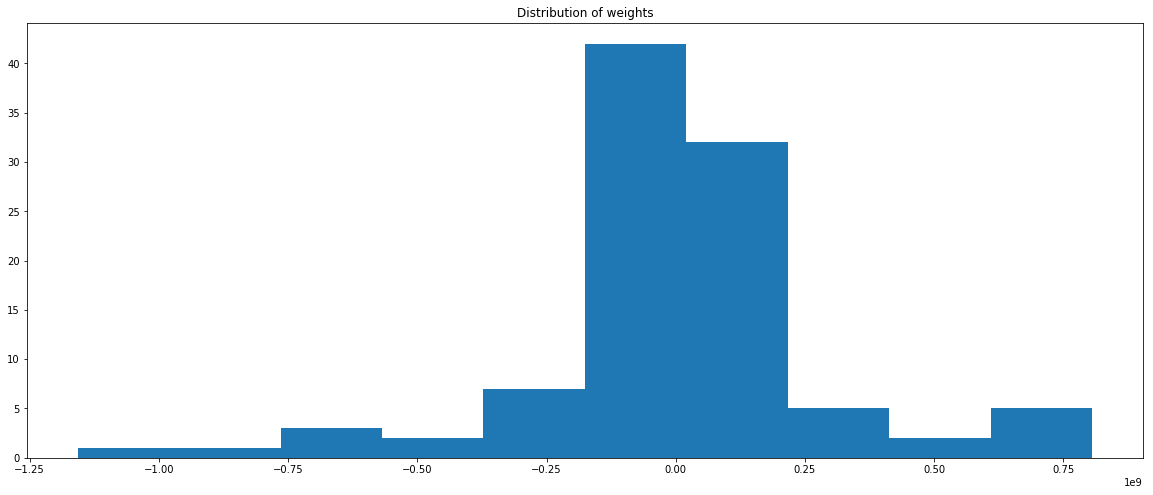

In [5]:
weights = clf.dual_coef_
plt.figure(figsize=(20, 8))
plt.hist(weights)
plt.title("Distribution of weights")

## functional derivative

$$ \frac{1}{\Delta x} \nabla T^\text{ML}(\mathbf{n}) = \bar{T}\sum_{j=1}^{M}\alpha_j'(\mathbf{n}_j - \mathbf{n})k(\mathbf{n}_j, \mathbf{n}) = \frac{1}{h} \sum_{j=1}^{M}\omega_j \gamma 2(\mathbf{n}_j - \mathbf{n})k(\mathbf{n}_j, \mathbf{n})$$

In [0]:
def rbf_kernel(X, X_train, gamma):
    return np.exp(-gamma*np.sum(np.square(X[:, :, np.newaxis] - np.transpose(X_train)[np.newaxis, :, :]), 1))

def predict(X, X_train, weights, gamma):
    return np.sum(weights[np.newaxis, :]*rbf_kernel(X, X_train, gamma), 1)

def functional_derivative(X, X_train, weights, gamma):
    return 1/h*np.sum(weights[np.newaxis, :]*2*gamma*(X[:, :, np.newaxis] - np.transpose(X_train)[np.newaxis, :, :])*rbf_kernel(X, X_train, gamma)[:, np.newaxis, :], 2)


In [0]:
sample_dataset = "recreate_sample"

with open(os.path.join(datadir, sample_dataset, 'dataset.pkl'), 'rb') as f:
    np_x_sample, np_potential_sample, np_wavefunction_sample, np_energies_sample, np_density_sample, np_kenergies_sample, _, G, h = unpack_dataset(N, pickle.load(f))
    

In [34]:
np_density_sample.shape

(1, 500)

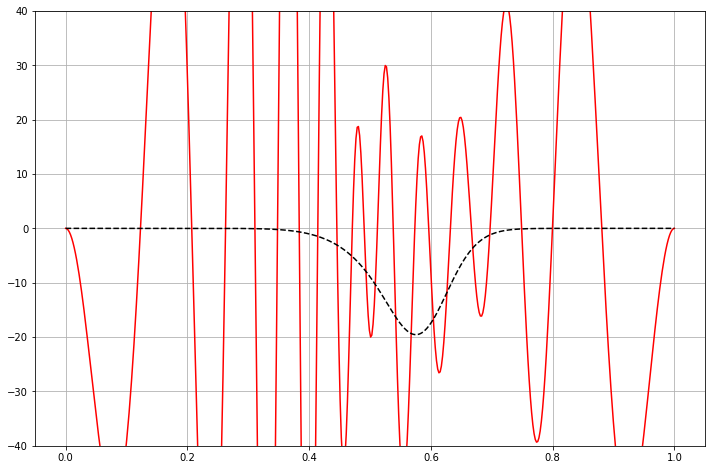

In [33]:
X_sample = np_density_sample

f_deriv = functional_derivative(X_sample, X_train, weights, gamma)[0, :]

plt.figure(figsize=(12, 8))
plt.plot(np_x, f_deriv, 'r')
plt.plot(np_x, np_potential_sample[0], '--k')
plt.ylim([-40, 40])
plt.grid(True)
plt.show()

### PCA

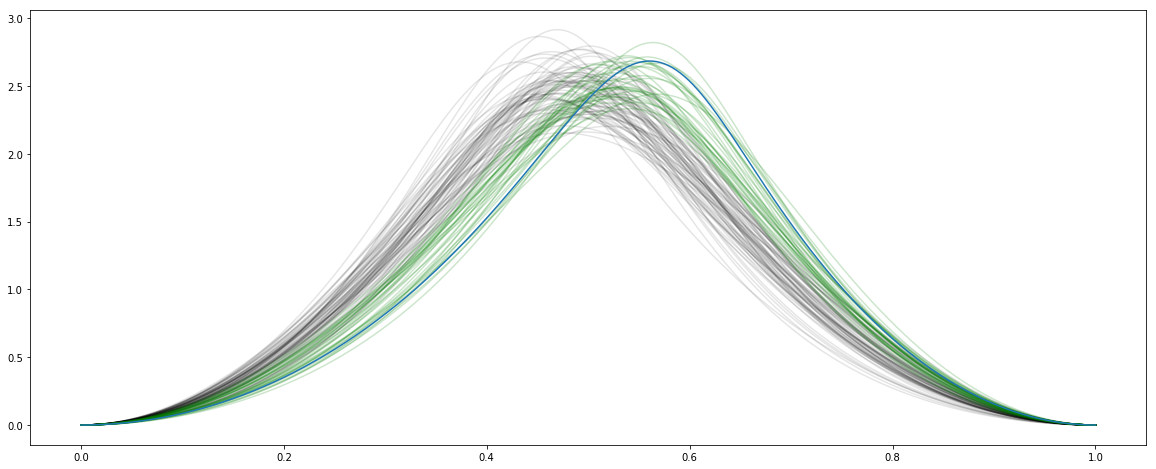

In [38]:
m = 30

norm_closest = np.sum(np.square(X_sample - X_train), -1)
idx = np.argpartition(norm_closest, m)
X_closest = X_train[idx[:m]]

plt.figure(figsize=(20, 8))
plt.plot(np_x, X_train[idx[m:]].transpose(), 'k', alpha=0.1)
plt.plot(np_x, X_closest.transpose(), 'g', alpha=0.2)
plt.plot(np_x, X_sample[0], 'C0')
plt.show()

In [0]:
l = 5
X = X_sample - X_closest
C = np.matmul(np.transpose(X), X)/m

In [41]:
C.shape

(500, 500)

In [42]:
eigen_vals, eigen_vecs = np.linalg.eig(C)
eigen_vals = np.real(eigen_vals)
eigen_vecs = np.real(eigen_vecs)

eigen_vecs.shape

(500, 500)

In [43]:
select_eigen_vecs = eigen_vecs[:, :l]
P_ml = np.matmul(select_eigen_vecs, np.transpose(select_eigen_vecs))
P_ml.shape

(500, 500)

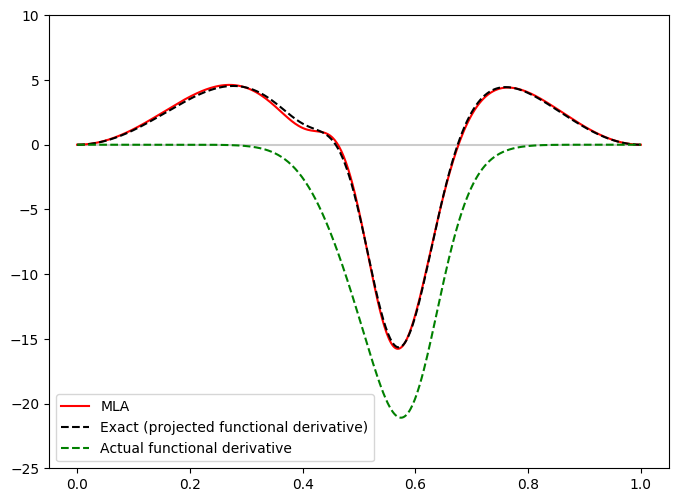

In [46]:
f_deriv_proj = np.matmul(P_ml, f_deriv)
potential_proj = np.matmul(P_ml, np_potential_sample[0])

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np_x, np.zeros_like(np_x), 'k', alpha=0.2)
plt.plot(np_x, f_deriv_proj, 'r', label="MLA")
plt.plot(np_x, potential_proj, '--k', label='Exact (projected functional derivative)')
plt.plot(np_x, potential_sample, '--g', label='Actual functional derivative')
plt.ylim([-25, 10])
plt.legend(loc="best")
plt.show()